In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import session_info
session_info.show()

/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


In [3]:
sc.settings.set_figure_params(dpi=80)

In [4]:
os.getcwd()

'/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/TissueTypist/CamU/tissuetypist_package'

# Read the objects

In [5]:
adata_dir = '/rfs/project/rfs-iCNyzSAaucw/kk837/data_objects/Foetal/VisiumHD'
sample_id = 'HEA_FOET14880396'

In [6]:
!ls {adata_dir}

archived-Dec2024_HEA_FOET14880396_b2c.h5ad
cellcharter
cellphonedb
for_Theo
HEA_AD14880301_b2c.h5ad
HEA_FOET14880396_8um-bins_filtered.h5ad
HEA_FOET14880396_8um-bins_filtered_lognorm.h5ad
HEA_FOET14880396_b2c_cells_filtered_celltype-selected_lognorm.h5ad
HEA_FOET14880396_b2c_cells_filtered.h5ad
HEA_FOET14880396_b2c_cells_filtered_lognorm.h5ad
HEA_FOET14880396_b2c_cells_filtered_lognorm_morpho_obs.csv
HEA_FOET14880396_b2c_cells.h5ad
HEA_FOET14880396_b2c.h5ad
HEA_FOET14880397_b2c_cells_filtered.h5ad
HEA_FOET14880397_b2c_cells_filtered_lognorm.h5ad
HEA_FOET14880397_b2c_cells.h5ad
HEA_FOET14880397_b2c.h5ad
subsets


In [7]:
# read in b2c object
adata = sc.read_h5ad(f'{adata_dir}/{sample_id}_b2c.h5ad') # read 2um object which has b2c cell grouping - see tutorial - https://nbviewer.org/github/Teichlab/bin2cell/blob/main/notebooks/demo.ipynb 
cdata = sc.read_h5ad(f'{adata_dir}/{sample_id}_b2c_cells_filtered_lognorm.h5ad') # read b2c object

In [8]:
# read in 8um object to get tt_prediction results
adata_8um = sc.read_h5ad(f'{adata_dir}/{sample_id}_8um-bins_filtered.h5ad',backed='r')
adata_8um

AnnData object with n_obs × n_vars = 311232 × 18085 backed at '/rfs/project/rfs-iCNyzSAaucw/kk837/data_objects/Foetal/VisiumHD/HEA_FOET14880396_8um-bins_filtered.h5ad'
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'binned_8_row', 'binned_8_col', 'section', 'sliding_window_assignment', 'window_col', 'window_row', 'tt_prediction'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

,tt_prediction
s_008um_00301_00321-1,AV ring
s_008um_00602_00290-1,Great vessel
s_008um_00377_00750-1,Ventricle - Trabeculated
s_008um_00383_00696-1,Ventricle - Trabeculated
s_008um_00526_00291-1,Great vessel
...,...
s_008um_00653_00166-1,Adventitia - GV
s_008um_00353_00477-1,Ventricle - Compact
s_008um_00565_00244-1,Adventitia - GV
s_008um_00373_00222-1,Atrium


In [9]:
anno_df = adata_8um.obs[['tt_prediction']].copy()
anno = 'tt_prediction'
cell_grouping = 'labels_joint'

# Import annotations from loupe browser

In [10]:
def map_loupe_to_b2c(
        adata,
        cdata,
        anno_df,
        anno,
        cell_grouping = 'labels_he_expanded', 
        ):
     

    # Calculate the binned row and column indices in adata
    adata.obs['binned_8_row'] = adata.obs['array_row'] // 4
    adata.obs['binned_8_col'] = adata.obs['array_col'] // 4

    # Create a combined index in adata and set it as the index
    adata.obs['mapping_index_08'] = 's_008um_' + adata.obs['binned_8_row'].astype(str).str.zfill(5) + '_' + adata.obs['binned_8_col'].astype(str).str.zfill(5) + '-1'
    adata.obs['mapping_index_08'].value_counts() # most should have 16 but there are some on the tissue edge that actually have less due to partial overlap 

    # read annotations from df and map to the 2um object 
    print('annotations to map:')
    print(anno_df.head(5))
    mapping_dict = pd.Series(anno_df[anno].values,index=anno_df.index).to_dict()
    adata.obs[anno] = adata.obs['mapping_index_08'].map(mapping_dict) # update 2um object 

    # assign annotation to cells by pandas.Series.mode(). The mode is the value that appears most often which captures the most frequent annotation for that cell from 2um data
    filtered_data = adata.obs[(adata.obs[cell_grouping] != 0) & adata.obs[anno].notna()]
    cell_annotation = (
        filtered_data.groupby(cell_grouping)[anno]
        .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    )
    cell_annotation.index = cell_annotation.index.astype('str')
    cdata.obs[anno] = cdata.obs.index.map(cell_annotation).astype('category') # label cells 
    print('Annotations in b2c object:')
    print(cdata.obs[anno].value_counts())

map_loupe_to_b2c(adata,
                 cdata,
                 anno_df,
                 anno,
                 cell_grouping)

annotations to map:
                                  tt_prediction
s_008um_00301_00321-1                   AV ring
s_008um_00602_00290-1              Great vessel
s_008um_00377_00750-1  Ventricle - Trabeculated
s_008um_00383_00696-1  Ventricle - Trabeculated
s_008um_00526_00291-1              Great vessel
Annotations in b2c object:
tt_prediction
Ventricle - Compact          43759
Adventitia - GV              24215
Atrium                       11901
Great vessel                 11489
Ventricle - Trabeculated      8742
VCS - Distal                  5460
VCS - Proximal                4430
AV ring                       4371
Endocardium - Atrial          2857
Epicardium                    2108
Ductus arteriosus             2050
Endocardium - Ventricular     1964
SAnode                        1559
Endocardial cusion            1264
AVnode                         674
Coronary vessel                625
Valves                         526
Name: count, dtype: int64


# Plot

In [13]:
AnnotationPalette={ 
    'Atrium':'#eac075',
        'Ventricle - Compact':'#f1acfa',
     'Ventricle - Trabeculated':'#f09951',
        'SAnode':'#8A2BE2',
        'AVnode':'#062b4a',
    'VCS - Proximal':'#FFFF00',
        'VCS - Distal':'#7FFFD4',
        'Epicardium':'#01ccc8',
        'Endocardium - Atrial':'#DC143C',
        'Endocardium - Ventricular':'#f53527',
        'Endocardial cusion':'#ff7e97',
        'Great vessel':'#ff9b6e',
    'Ductus arteriosus':'#8a6800',
        'Coronary vessel':'#206601',
        'Adventitia - Coronary':'#CAFF70',
     'Adventitia - GV':'#005aa0',
        'AV ring':'#e478ff',
    'Valves':'#3300FF',
    'LN':'#9088ff',
}

/tmp/ipykernel_237158/3235274587.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(cdata,


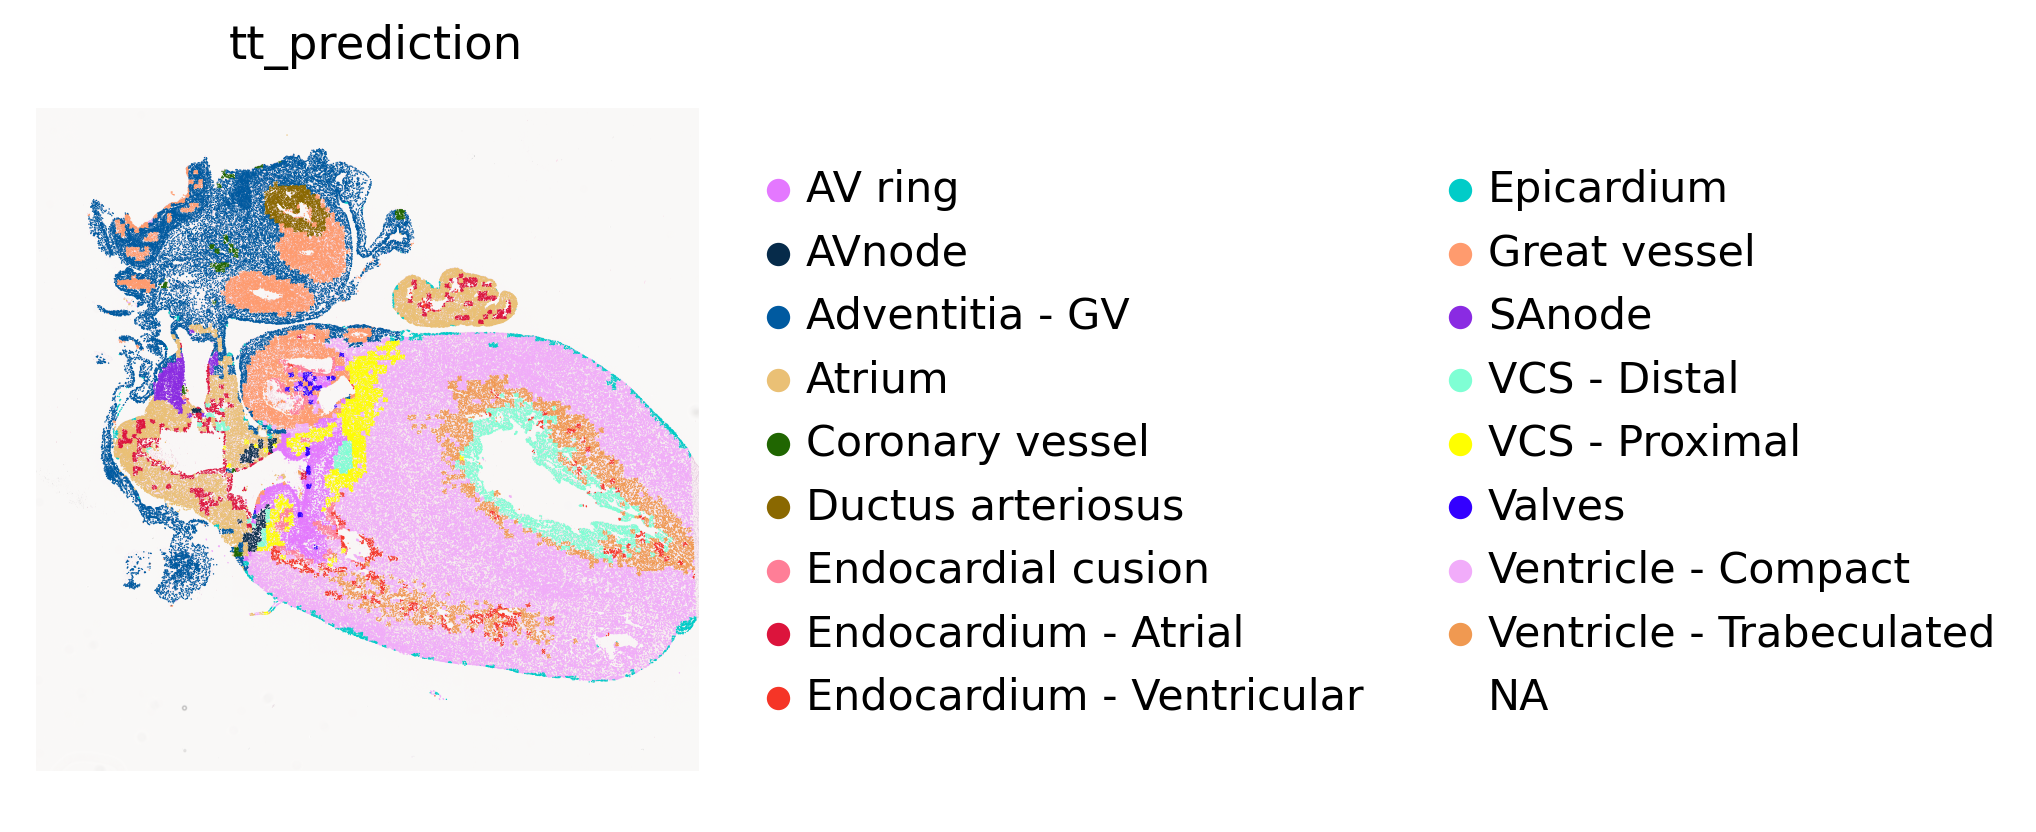

In [14]:
sc.settings.set_figure_params(dpi=120)
sc.pl.spatial(cdata, 
                  color=anno, 
                  img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer",
                  size=1.5,alpha_img=0.3,
                  frameon=False,palette=AnnotationPalette
                 )

# Save cdata

In [15]:
cdata.write(f'{adata_dir}/{sample_id}_b2c_cells_filtered_lognorm.h5ad')
cdata

AnnData object with n_obs × n_vars = 129803 × 18047
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'fine_grain_4Jan2025', 'HistologicalAnnotation', 'SANaxis_landmarks', 'SAN_axis', 'SAN_axis_bin_annot', 'tt_prediction'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HistologicalAnnotati